**Traffic Sign Identification Using Convolutional Neural Networks for Safer Roads**

**1. Importing Libraries**

In [ ]:
# Fundamental classes
import numpy as np
import pandas as pd
import tensorflow as tf
import os


In [ ]:
# Image related
import cv2
from PIL import Image

In [ ]:
# Performance Plot
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [ ]:
# Time
import time
import datetime

**2. Creating Custom Function**

In [ ]:
# Performance Plot
def plot_performance(history = None, figure_directory = None, ylim_pad = [0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize = (20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2)) - ylim_pad[0]
    max_y = max(max(y1), max(y2)) + ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n', fontsize = 17)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc = 'upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2)) - ylim_pad[1]
    max_y = max(max(y1), max(y2)) + ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n', fontsize = 17)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc = 'upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory + "/history")

    plt.show()

**3. Loading Training Dataset (German Traffic Sign Recognition Benchmark)**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:07<00:00, 86.5MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [ ]:
import zipfile
import os

dataset_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
unzip_dir = '/content/gtsrb/'

# Check if the path is a zip file and extract
zip_file = os.path.join(dataset_path, 'gtsrb-german-traffic-sign.zip')
if zipfile.is_zipfile(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)

# Verify the extraction
print(f"Files extracted to {unzip_dir}")


Files extracted to /content/gtsrb/


In [ ]:
import os

# List the files in the kaggle dataset folder
file_list = os.listdir('/root/.cache/kagglehub/datasets/')
print(file_list)


['meowmeowmeowmeowmeow']


In [ ]:
# List the files in the 'meowmeowmeowmeowmeow' directory
file_list = os.listdir('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/')
print(file_list)


['gtsrb-german-traffic-sign']


In [ ]:
# List the files in the 'gtsrb-german-traffic-sign' directory
file_list = os.listdir('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/')
print(file_list)


['1.complete', 'versions']


In [ ]:
# List the files in the 'versions' directory
file_list = os.listdir('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions')
print(file_list)


['1']


In [ ]:
# List the files in the '1' version directory
file_list = os.listdir('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1')
print(file_list)


['Train', 'train', 'Test', 'Meta.csv', 'Test.csv', 'Meta', 'test', 'meta', 'Train.csv']


In [ ]:
import pandas as pd

# Load the Train.csv file
train_df = pd.read_csv('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train.csv')

# Display the first few rows of the training data
print(train_df.head())


   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [ ]:
# Load the Meta.csv file
meta_df = pd.read_csv('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Meta.csv')

# Display the first few rows of the metadata
print(meta_df.head())


          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22


In [ ]:
import os
import cv2
import numpy as np

# Initialize empty lists for data and labels
data = []
labels = []

# Path to the train images (adjust if necessary)
train_dir = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/train/'

# Loop through the subdirectories (classes)
for label in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, label)

    if os.path.isdir(class_dir):  # Only consider directories (class folders)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)

            # Read the image and resize to a fixed size (e.g., 32x32)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (32, 32))  # Resize images to a consistent shape

            # Append the image and corresponding label to the lists
            data.append(image)
            labels.append(int(label))  # Assuming the folder name is the label

# Convert the lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Print the shapes of data and labels
print(data.shape, labels.shape)


(39209, 32, 32, 3) (39209,)


In [ ]:
import pandas as pd

# Define the path to the Meta.csv file
meta_file_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Meta.csv'

# Load the Meta.csv file
meta_df = pd.read_csv(meta_file_path)

# Display the first few rows of the metadata
meta_df.head()


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


from matplotlib import pyplot as plt
_df_0['ClassId'].plot(kind='hist', bins=20, title='ClassId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['ShapeId'].plot(kind='hist', bins=20, title='ShapeId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Path').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('SignId').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='ClassId', y='ShapeId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ColorId']
  ys = series['ClassId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('ColorId', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Path')):
  _plot_series(series, series_name, i)
  fig.legend(title='Path', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ColorId')
_ = plt.ylabel('ClassId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ColorId']
  ys = series['ClassId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('ColorId', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('SignId')):
  _plot_series(series, series_name, i)
  fig.legend(title='SignId', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ColorId')
_ = plt.ylabel('ClassId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ColorId']
  ys = series['ShapeId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('ColorId', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Path')):
  _plot_series(series, series_name, i)
  fig.legend(title='Path', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ColorId')
_ = plt.ylabel('ShapeId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ColorId']
  ys = series['ShapeId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('ColorId', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('SignId')):
  _plot_series(series, series_name, i)
  fig.legend(title='SignId', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ColorId')
_ = plt.ylabel('ShapeId')

from matplotlib import pyplot as plt
_df_9['ClassId'].plot(kind='line', figsize=(8, 4), title='ClassId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['ShapeId'].plot(kind='line', figsize=(8, 4), title='ShapeId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['SignId'].value_counts()
    for x_label, grp in _df_11.groupby('Path')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Path')
_ = plt.ylabel('SignId')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Path'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='ClassId', y='Path', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['SignId'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='ClassId', y='SignId', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Path'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='ShapeId', y='Path', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['SignId'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='ShapeId', y='SignId', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

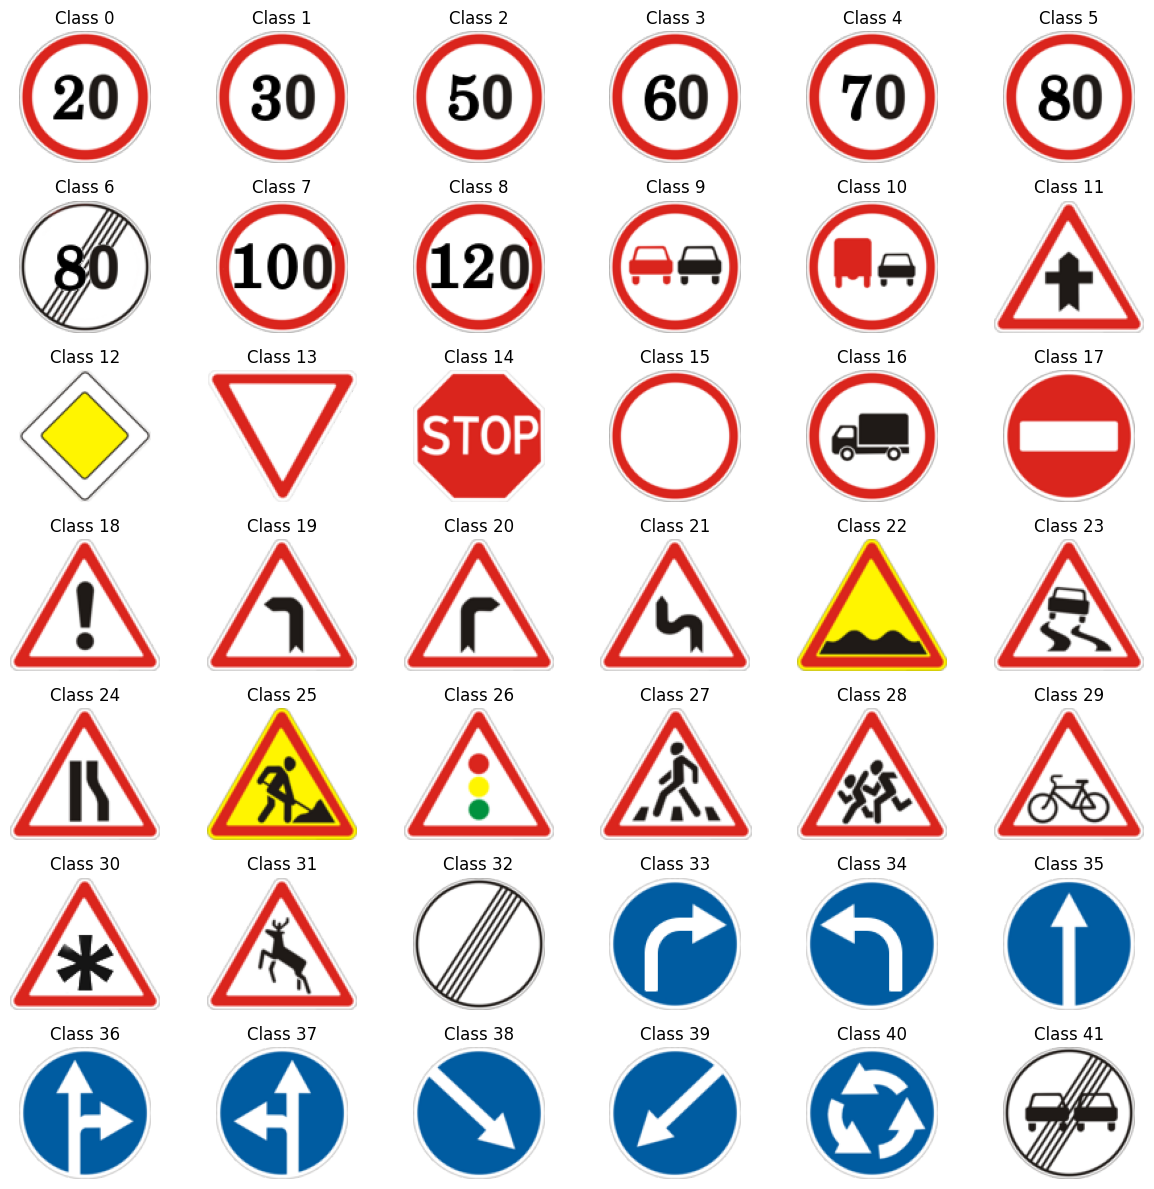

In [ ]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the Meta.csv file
meta_file_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Meta.csv'

# Load the Meta.csv file
meta_df = pd.read_csv(meta_file_path)

# Sort the metadata by ClassId and reset the index
meta_sorted = meta_df.sort_values(by="ClassId").reset_index(drop=True)

# Define the path to the dataset (replace with your actual dataset path)
dataset_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/'

# Create a grid of subplots
fig, axs = plt.subplots(7, 6, figsize=(12, 12))

# Loop through all 42 classes
for i in range(42):
    img_path = os.path.join(dataset_path, meta_sorted.iloc[i]["Path"])
    img = Image.open(img_path)

    # Determine the subplot row and column
    row, col = divmod(i, 6)
    axs[row, col].imshow(img)
    axs[row, col].axis("off")
    axs[row, col].set_title(f"Class {meta_sorted.iloc[i]['ClassId']}")

# Remove any unused subplots (if fewer than 42 images exist)
for j in range(42, 7 * 6):
    row, col = divmod(j, 6)
    axs[row, col].axis("off")

plt.tight_layout()
plt.show()


**4. Data Splitting**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)


In [ ]:
# Convert the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

**5. Building & Compiling Model**

In [ ]:
# Model construction
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

# # Initial Conv layers
# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(rate=0.2))

# # Middle Conv layers
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(rate=0.25))

# # Final Conv layers
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(rate=0.3))

# # Fully connected layers
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(rate=0.4))
# model.add(Dense(43, activation='softmax'))

# Model compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,542,443 (9.70 MB)

 Trainable params: 2,542,443 (9.70 MB)

 Non-trainable params: 0 (0.00 B)

**6. Model Training**

In [ ]:
# Training
with tf.device('/GPU:0'):
    epochs = 10
    history1 = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.4707 - loss: 3.4289 - val_accuracy: 0.9685 - val_loss: 0.1342
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.9464 - loss: 0.2144 - val_accuracy: 0.9851 - val_loss: 0.0644
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.9687 - loss: 0.1200 - val_accuracy: 0.9883 - val_loss: 0.0437
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9733 - loss: 0.0952 - val_accuracy: 0.9765 - val_loss: 0.0811
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.9554 - loss: 0.1744 - val_accuracy: 0.9884 - val_loss: 0.0382
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9879 - loss: 0.0425 - val_accuracy: 0.9954 - val_loss: 0.0246
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9921 - loss: 0.0277 - val_accuracy: 0.9945 - val_loss: 0.0239
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.9861 - loss: 0.0502 - val_accu

**7. Visualising Training Performance**

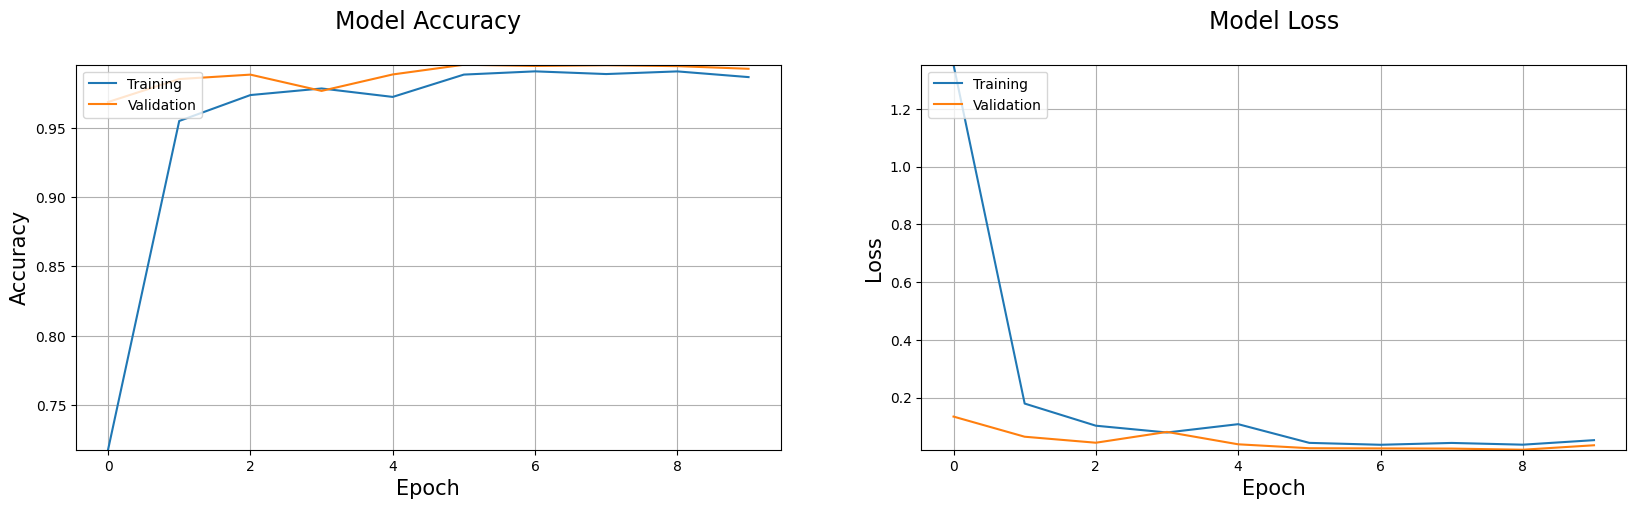

In [ ]:
# Performance visualization
plot_performance(history=history1)

In [ ]:
import pandas as pd

# Correct path to Test.csv
test_df = pd.read_csv('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Test.csv')

# Assuming the CSV has 'ClassId' as the label and 'Path' for image paths
labels = test_df["ClassId"].values
imgs = test_df["Path"].values

# Print first few rows to check
print(test_df.head())


   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


In [ ]:
# Check the shapes
print("Labels length:", len(labels))
print("Predictions length:", len(pred))


Labels length: 12630
Predictions length: 7842


In [ ]:
print(test_df["Path"].head())  # Print the first few image paths


0    Test/00000.png
1    Test/00001.png
2    Test/00002.png
3    Test/00003.png
4    Test/00004.png
Name: Path, dtype: object


In [ ]:
import os
print(os.getcwd())  # Print the current working directory


/content


In [ ]:
test_dir = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/'

# Initialize an empty list for test images
test_data = []

# Loop through the test CSV and load each image
for image_path in test_df["Path"].values:
    full_image_path = os.path.join(test_dir, image_path)  # Prepend the directory path

    # Check if the file exists
    if not os.path.exists(full_image_path):
        print(f"File not found: {full_image_path}")
        continue

    img = cv2.imread(full_image_path)  # Read the image
    if img is None:
        print(f"Error reading image: {full_image_path}")
        continue
    img = cv2.resize(img, (32, 32))  # Resize to 32x32 (or your required shape)
    test_data.append(img)

# Convert to numpy array
test_data = np.array(test_data)

# Print the shape of the test data to ensure all images are loaded
print(test_data.shape)


(12630, 32, 32, 3)


In [ ]:
pred = model.predict(test_data)
print("Predictions shape:", pred.shape)


395/395 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step
Predictions shape: (12630, 43)


In [ ]:
print("Labels shape:", labels.shape)
print("Pred shape:", pred.shape)


Labels shape: (12630,)
Pred shape: (7842,)


In [ ]:
print(batch.shape)  # Check the shape of your input batch


(32, 32, 3)


In [ ]:
model.summary()  # Check the input shape here


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,627,331 (29.10 MB)

 Trainable params: 2,542,443 (9.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,084,888 (19.40 MB)

In [ ]:
# Assuming test_data is a list of input samples
batch_size = 32
pred = []

# Iterate over the data in batches
for i in range(0, len(test_data), batch_size):
    batch = test_data[i:i+batch_size]

    # Check the shape of the batch
    print("Batch shape:", np.array(batch).shape)

    # Ensure the batch is in the correct format (e.g., TensorFlow tensor)
    batch_tensor = tf.convert_to_tensor(batch)

    # Predict using the model
    pred_batch = model.predict(batch_tensor)
    pred.extend(pred_batch)


Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Batch shape: (32, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
pred = []
for i in range(0, len(test_data), batch_size):
    batch = test_data[i:i + batch_size]
    batch_tensor = tf.convert_to_tensor(batch)  # Convert batch to tensor if necessary

    # Predict for the batch
    pred_batch = model.predict(batch_tensor)
    pred.extend(pred_batch)  # Collect predictions from the batch

# After looping through all batches, you should have all predictions in 'pred'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90

In [ ]:
print(np.array(pred).shape)


(12630, 43)


In [ ]:
# Convert probabilities to class labels
pred_labels = np.argmax(pred, axis=-1)  # This gives you the index of the highest probability for each sample
print(pred_labels.shape)  # Should be (12630,) if you want the labels (one per sample)


(12630,)


**8. Loading Test Dataset & Evaluating Model**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Assuming 'labels' are your ground truth labels
accuracy = accuracy_score(labels, pred_labels)
f1 = f1_score(labels, pred_labels, average='weighted')  # Adjust the 'average' method if needed
recall = recall_score(labels, pred_labels, average='weighted')  # Similar to F1, adjust 'average'

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)


Accuracy: 0.959144893111639
F1 Score: 0.9588267230792487
Recall: 0.959144893111639


In [ ]:
from sklearn.metrics import classification_report

# Convert the raw predictions to class labels by selecting the index of the highest probability
pred_labels = np.argmax(pred, axis=-1)  # Shape should be (12630,) now

# Now, you can generate the classification report
print(classification_report(labels, pred_labels))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.94      0.98      0.96       720
           2       0.94      0.98      0.96       750
           3       0.89      0.98      0.94       450
           4       0.99      0.97      0.98       660
           5       0.95      0.95      0.95       630
           6       0.93      0.84      0.88       150
           7       0.97      0.96      0.97       450
           8       0.99      0.94      0.97       450
           9       0.96      1.00      0.98       480
          10       1.00      0.98      0.99       660
          11       0.97      0.96      0.96       420
          12       1.00      0.91      0.95       690
          13       0.98      1.00      0.99       720
          14       0.97      0.98      0.98       270
          15       0.77      1.00      0.87       210
          16       0.99      1.00      0.99       150
          17       1.00    

In [ ]:
# Save the model in Keras' native format (the recommended format)
model.save('traffic_classifier.keras')


In [ ]:
import os
print(os.listdir('/content/'))


['.config', 'sample_data']


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [ ]:
import pandas as pd

# Load the test labels using the correct path
test_df = pd.read_csv('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Test.csv')

# Assuming the CSV has 'ClassId' as the label and 'Path' for image paths
labels = test_df["ClassId"].values
imgs = test_df["Path"].values

# Print the first few rows to check
print(test_df.head())


   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf

# Initialize an empty list to store image data
data = []

# Use GPU for processing if available
with tf.device('/GPU:0'):
    for img_path in test_df["Path"].values:
        # Construct the full path to the image
        image_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/' + img_path
        image = Image.open(image_path)  # Open the image
        image = image.resize((30, 30))  # Resize to the desired dimensions
        data.append(np.array(image))  # Convert to numpy array and append to the list

# Convert the list to a numpy array
X_test = np.array(data)

# Verify the shape of the input data
print("Shape of X_test:", X_test.shape)  # Should be (n_samples, 30, 30, 3)


Shape of X_test: (12630, 30, 30, 3)


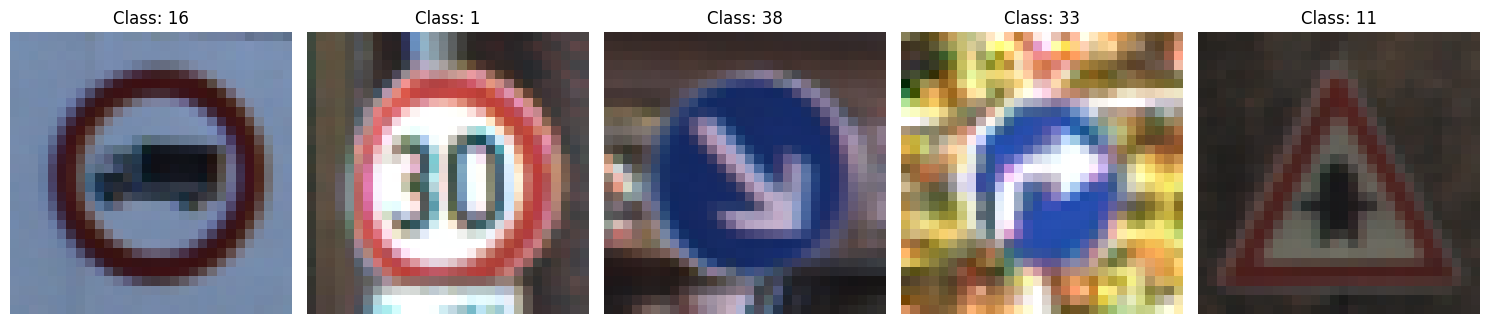

In [ ]:
# Check the test dataset images 1 - 5 (unordered)
plt.figure(figsize=(15, 5))

for i in range(0, 5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Class: {labels[i]}')

plt.tight_layout()
plt.show()

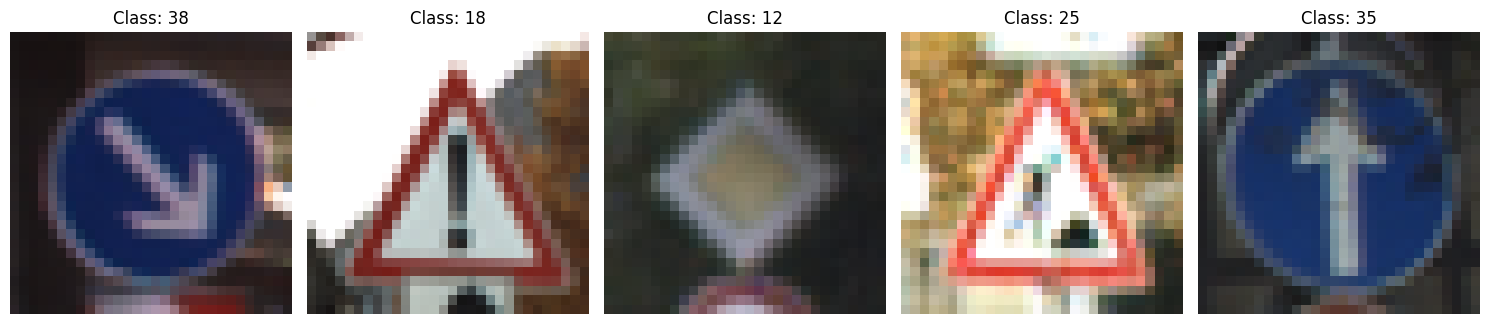

In [ ]:
# Check the test dataset images 6 - 10 (unordered)
plt.figure(figsize=(15, 5))

for i in range(5, 10):
    plt.subplot(1, 5, i + 1 - 5)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Class: {labels[i]}')

plt.tight_layout()
plt.show()

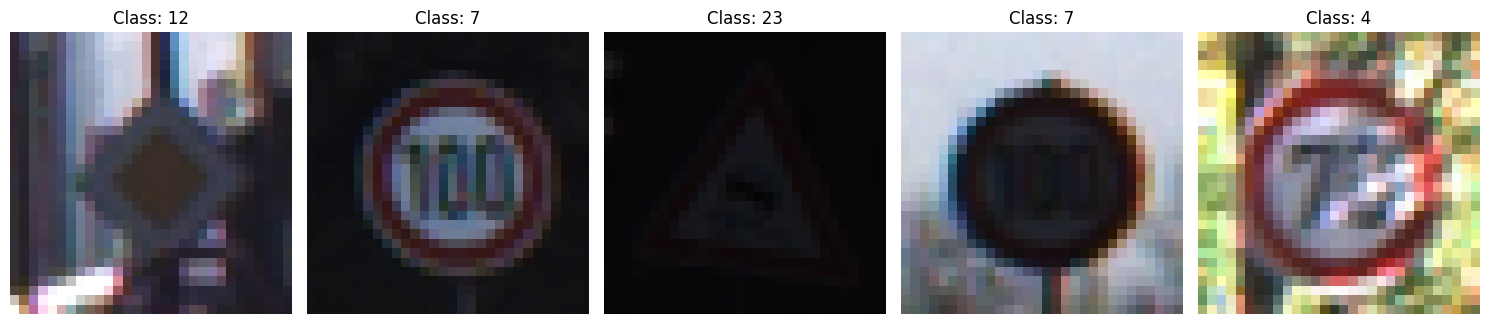

In [ ]:
# Check the test dataset images 11 - 15 (unordered)
plt.figure(figsize=(15, 5))

for i in range(10, 15):
    plt.subplot(1, 5, i + 1 - 10)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Class: {labels[i]}')

plt.tight_layout()
plt.show()

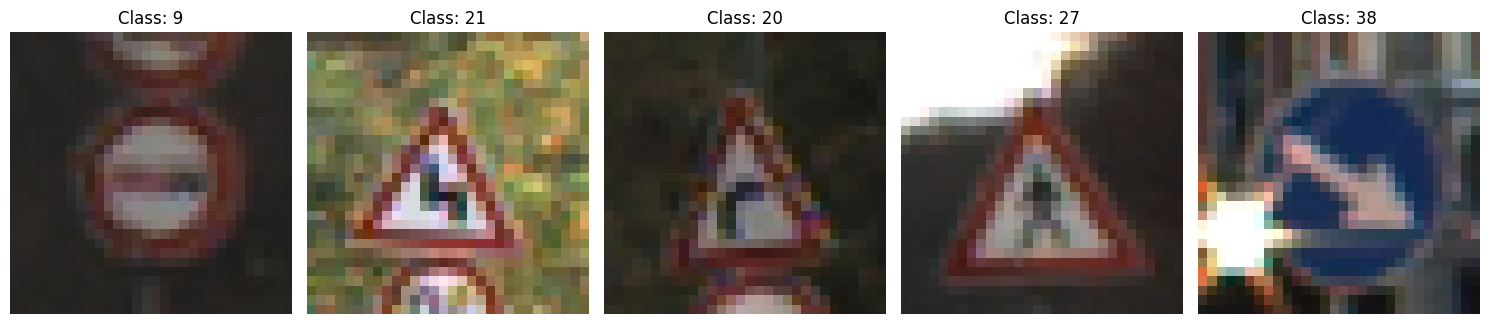

In [ ]:
# Check the test dataset images 16 - 20 (unordered)
plt.figure(figsize=(15, 5))

for i in range(15, 20):
    plt.subplot(1, 5, i + 1 - 15)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Class: {labels[i]}')

plt.tight_layout()
plt.show()

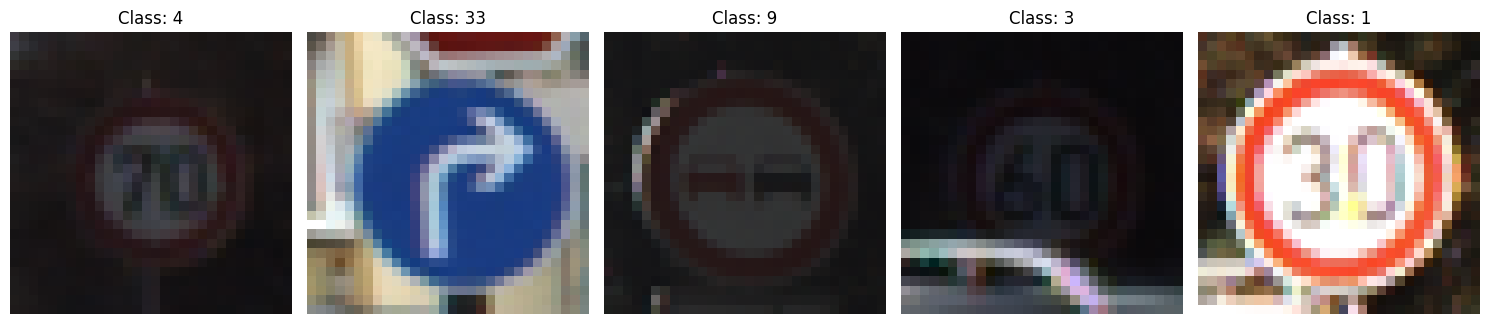

In [ ]:
# Check the test dataset images 21 - 25 (unordered)
plt.figure(figsize=(15, 5))

for i in range(20, 25):
    plt.subplot(1, 5, i + 1 - 20)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Class: {labels[i]}')

plt.tight_layout()
plt.show()

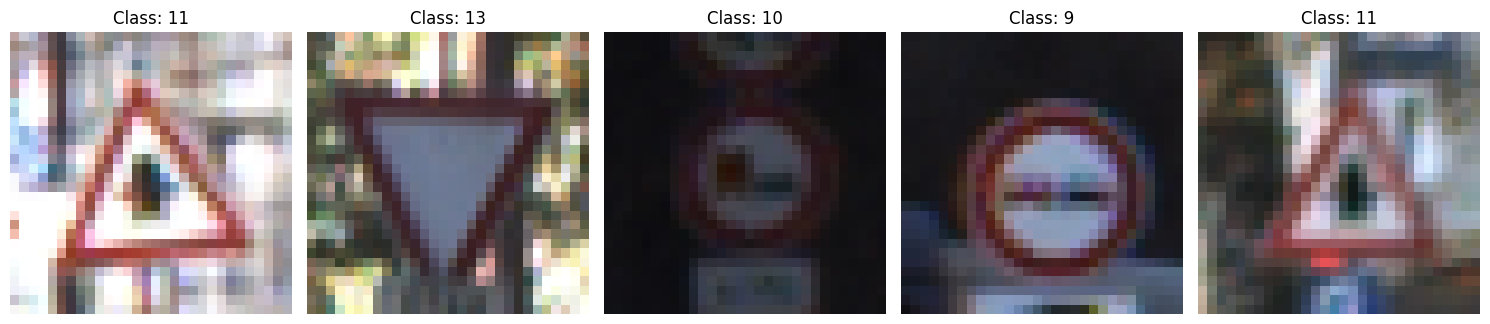

In [ ]:
# Check the test dataset images 26 - 30 (unordered)
plt.figure(figsize=(15, 5))

for i in range(25, 30):
    plt.subplot(1, 5, i + 1 - 25)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Class: {labels[i]}')

plt.tight_layout()
plt.show()

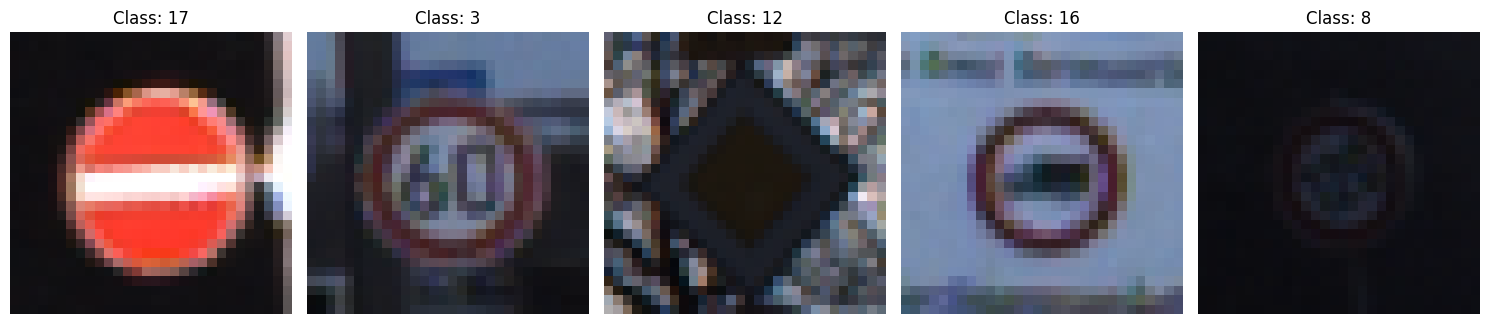

In [ ]:
# Check the test dataset images 36 - 40 (unordered)
plt.figure(figsize=(15, 5))

for i in range(35, 40):
    plt.subplot(1, 5, i + 1 - 35)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Class: {labels[i]}')

plt.tight_layout()
plt.show()

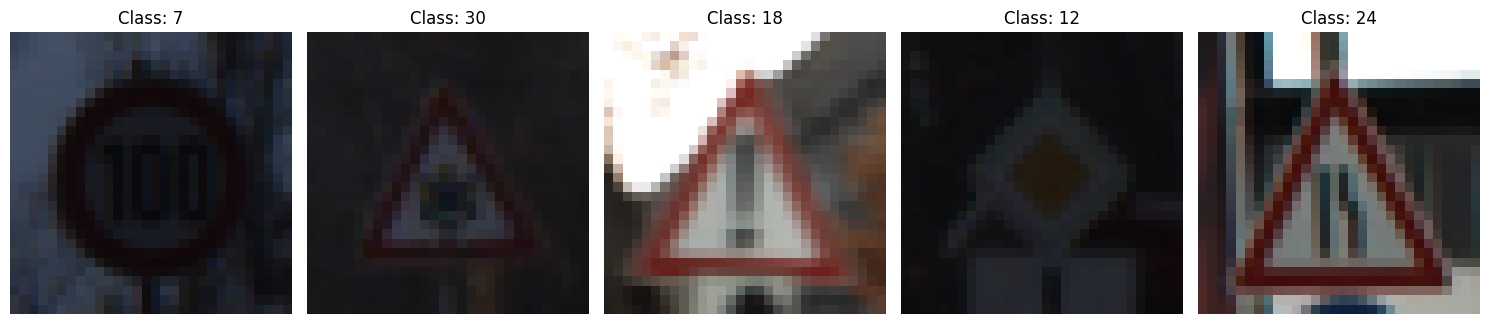

In [ ]:
# Check the test dataset images 41 - 45 (unordered)
plt.figure(figsize=(15, 5))

for i in range(40, 45):
    plt.subplot(1, 5, i + 1 - 40)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Class: {labels[i]}')

plt.tight_layout()
plt.show()


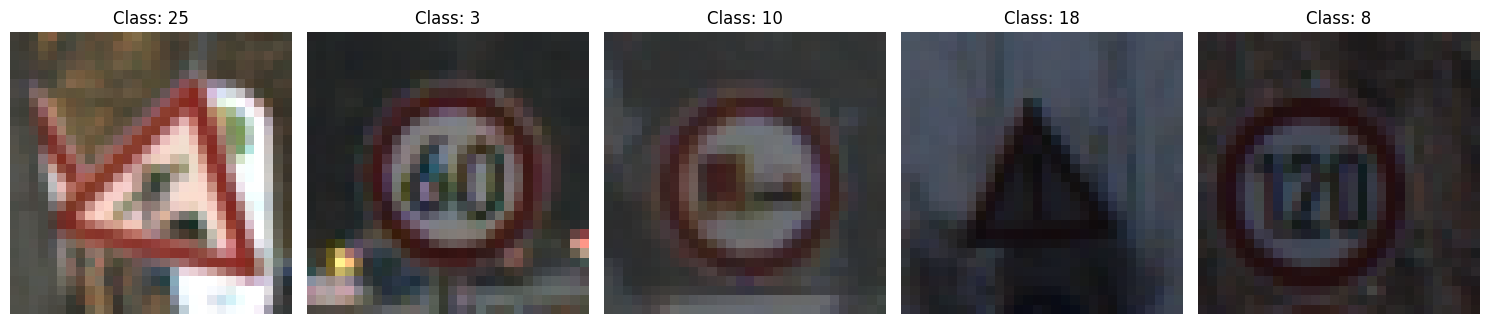

In [ ]:
# Check the test dataset images 46 - 50 (unordered)
plt.figure(figsize=(15, 5))

for i in range(45, 50):
    plt.subplot(1, 5, i + 1 - 45)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'Class: {labels[i]}')

plt.tight_layout()
plt.show()


In [ ]:
import os

# Check if the model file exists in the current directory
if os.path.exists('traffic_classifier.h5'):
    print("Model file found!")
else:
    print("Model file not found!")


Model file not found!


Resized X_test shape: (12630, 32, 32, 3)
395/395 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step


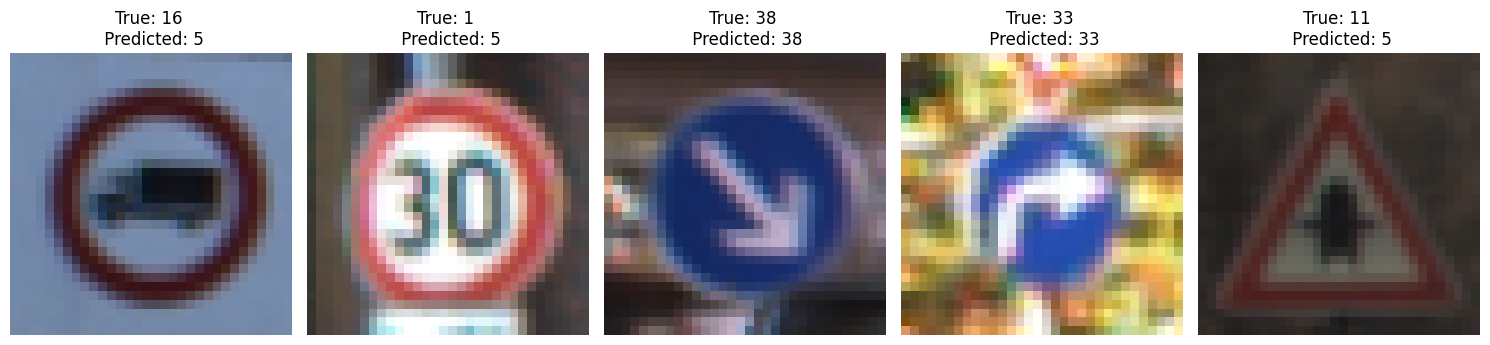

In [ ]:
# Resize images to 32x32 while preserving 3 color channels (RGB)
X_test_resized = np.array([cv2.resize(img, (32, 32)) for img in X_test])

# Check the shape of the resized images
print("Resized X_test shape:", X_test_resized.shape)  # Should be (n_samples, 32, 32, 3)

# Normalize the images (optional, depending on your model's training process)
X_test_resized = X_test_resized / 255.0  # Optional if your model expects [0, 1] normalized images

# Now predict
predictions = model.predict(X_test_resized)
predicted_classes = np.argmax(predictions, axis=1)

# Display the images and their labels
plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test_resized[i])  # Display the resized image
    plt.axis('off')
    plt.title(f'True: {labels[i]} \n Predicted: {predicted_classes[i]}')

plt.tight_layout()
plt.show()
